In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as rnd_frst
from sklearn.model_selection import cross_val_score, GridSearchCV, \
                                    LeaveOneOut, RepeatedKFold, train_test_split
from sklearn.metrics import make_scorer, roc_curve, auc, log_loss, \
                            f1_score, brier_score_loss, precision_score, recall_score, \
                            confusion_matrix, ConfusionMatrixDisplay


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/march-machine-learning-mania-2025/Conferences.csv
/kaggle/input/march-machine-learning-mania-2025/SeedBenchmarkStage1.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeedRoundSlots.csv
/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/WSecondaryTourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/WGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/MSeasons.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySlots.csv
/kaggle/input/march-machine-learning-mania-2025/MSecondaryTourneyTeams.csv
/kaggle/input/march-machine-learning-mania-20

In [3]:
# Team names, IDs; conferences
MTeams = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MTeams.csv')
WTeams = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WTeams.csv')

MTeamConfs = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MTeamConferences.csv')
WTeamConfs = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WTeamConferences.csv')


# Dates and MM regions
# Day 132 is Selection Sunday and Day 154 is men's championship game
MSeasons = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MSeasons.csv')
WSeasons = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WSeasons.csv')

# Seeds for MM, regions are W-Z and double seeds have a's or b's'
MSeeds = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeeds.csv')
WSeeds = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySeeds.csv')

# Regular season results (day 132 or earlier), WLoc is location of winning team
# Box scores are in the detail files
MRegSzn = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonCompactResults.csv')
MRegSznDetail = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv')
MConfTourney = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MConferenceTourneyGames.csv')

WRegSzn = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonCompactResults.csv')
WRegSznDetail = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonDetailedResults.csv')
WConfTourney = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WConferenceTourneyGames.csv')

# Tournament results (after day 132)
MTourney = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv')
MTourneyDetail = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyDetailedResults.csv')
MSlots = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySlots.csv')

WTourney = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyCompactResults.csv')
WTourneyDetail = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv')
WSlots = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySlots.csv')


# Rankings (not all systems necessarily available this year)
MRanks = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MMasseyOrdinals.csv')
SeedBenchmarks = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/SeedBenchmarkStage1.csv')


In [4]:
t_teams = pd.merge(MSeeds, MTeams[['TeamID','TeamName']], on='TeamID')
t_teams['RSeed'] = t_teams['Seed'].str[1:3].astype(int)
t_teams['Region'] = t_teams['Seed'].str[0]
t_teams['Seed'] = t_teams['Seed'].str[1:]

results = pd.merge(MTourney, t_teams, left_on=['WTeamID','Season'],right_on=['TeamID','Season'])
results = pd.merge(results, t_teams, left_on=['LTeamID','Season'],right_on=['TeamID','Season'])

results = results.drop(columns=['TeamID_x', 'TeamID_y', 'Seed_x','Seed_y','NumOT', 'WLoc','Region_x'])
results.columns = ['year','day','WID','WScore','LID','LScore','WTeam','WSeed','LTeam','LSeed','Region']

results.head()

,year,day,WID,WScore,LID,LScore,WTeam,WSeed,LTeam,LSeed,Region
0,1985,136,1116,63,1234,54,Arkansas,9,Iowa,8,X
1,1985,136,1120,59,1345,58,Auburn,11,Purdue,6,Z
2,1985,136,1207,68,1250,43,Georgetown,1,Lehigh,16,W
3,1985,136,1229,58,1425,55,Illinois St,9,USC,8,Y
4,1985,136,1242,49,1325,38,Kansas,3,Ohio,14,Z


I want to transform the data into a shape where we can see each team's per-game averages over the course of a season. Because of the original format, this requires some manipulation. I initially create a new dataframe where each row corresponds to one team's stats (For and Allowed) in a game, rather than each row only showing one overall game. Thus this dataframe is exactly twice the number of rows as the original box scores dataframe. That is done by the following function, which also incorprates the four factors (eFG%, TOV%, ORB%, and FT/FGA) and replaces the equivalent columns (). I then add a column to show which column the team played in that season.

In [5]:
r_box_raw = MRegSznDetail
t_box_raw = MTourneyDetail

print("Shape of original df: ", r_box_raw.shape)

def reshape_box_scores(df):
    winning_stat_cols = [col for col in df.columns if col.startswith('W') and col != 'WTeamID' and col != 'WLoc']
    losing_stat_cols = [col for col in df.columns if col.startswith('L') and col != 'LTeamID']
    
    # Create two separate dataframes - one for winning teams and one for losing teams
    winning_df = df[['WTeamID'] + winning_stat_cols].copy()
    winning_df.columns = [col.replace('W', 'For') if col.startswith('W') else 'team_id' 
                          for col in winning_df.columns]
    winning_df['win'] = 1
    
    # For losing teams
    losing_df = df[['LTeamID'] + losing_stat_cols].copy()
    losing_df.columns = [col.replace('L', 'All') if col.startswith('L') else 'team_id' 
                         for col in losing_df.columns]
    losing_df['loss'] = 0
    
    first_half = pd.concat([r_box_raw[['Season', 'DayNum']], winning_df, losing_df], axis=1)
    second_half = pd.concat([r_box_raw[['Season', 'DayNum']], losing_df, winning_df], axis=1)

    second_half.columns = first_half.columns

    result = pd.concat([first_half, second_half], ignore_index=True)

    return result

def four_factors(df):
    result = df
    result['fEFG%'] = ((result['ForFGM'] + (0.5 * result['ForFGM3'])) / result['ForFGA']) * 100
    
    result['fTO%'] = (result['ForTO'] / (result['ForFGA'] + (0.44 * result['ForFTA']) + result['ForTO'])) * 100
    result['aTO%'] = (result['AllTO'] / (result['AllFGA'] + (0.44 * result['AllFTA']) + result['AllTO'])) * 100
    
    result['fORB%'] = (result['ForOR'] / (result['ForOR'] + result['AllDR'])) * 100
    
    result['fFTrate'] = (result['ForFTA'] / result['ForFGA']) * 100
    result['aFTrate'] = (result['AllFTA'] / result['AllFGA']) * 100

    result['fAst_TO'] = result['ForAst'] / result['ForTO']
    result['fAst_TO'] = result['AllAst'] / result['AllTO']
    result['fFT%'] = (result['ForFTM'] / result['ForFTA']) * 100

    return result.round(2)

r_box_scores = reshape_box_scores(r_box_raw)
r_box_scores = four_factors(r_box_scores)

print("Shape of new df: ", r_box_scores.shape)
r_box_scores.head(10)

Shape of original df:  (118449, 34)
Shape of new df:  (236898, 42)


,Season,DayNum,ForTeamID,ForScore,ForFGM,ForFGA,ForFGM3,ForFGA3,ForFTM,ForFTA,...,AllPF,loss,fEFG%,fTO%,aTO%,fORB%,fFTrate,aFTrate,fAst_TO,fFT%
0,2003,10,1104,68,27,58,3,14,11,18,...,20,0,49.14,25.87,22.31,38.89,31.03,41.51,0.44,61.11
1,2003,10,1272,70,26,62,8,20,10,19,...,16,0,48.39,15.60,13.67,37.50,30.65,29.85,0.58,52.63
2,2003,11,1266,73,24,58,8,18,17,29,...,23,0,48.28,12.38,12.62,43.59,50.00,31.51,0.75,58.62
3,2003,11,1296,56,18,38,3,9,17,31,...,23,0,51.32,18.86,25.47,23.08,81.58,30.61,0.47,54.84
4,2003,11,1400,77,30,61,6,14,11,13,...,14,0,54.10,17.34,11.92,53.12,21.31,43.55,1.20,84.62
5,2003,11,1458,81,26,57,6,12,23,27,...,25,0,50.88,11.56,26.21,35.29,47.37,36.96,0.42,85.19
6,2003,12,1161,80,23,55,2,8,32,39,...,28,0,43.64,19.07,36.01,38.24,70.91,68.29,0.37,82.05
7,2003,12,1186,75,28,62,4,14,15,21,...,18,0,48.39,21.05,17.83,34.21,33.87,38.98,0.67,71.43
8,2003,12,1194,71,28,58,5,11,10,18,...,18,0,52.59,20.50,28.13,25.71,31.03,51.92,0.52,55.56
9,2003,12,1458,84,32,67,5,17,15,19,...,18,0,51.49,7.37,23.91,37.84,28.36,23.08,0.56,78.95


In [6]:
team_stats = r_box_scores.groupby(['ForTeamID','Season']).agg(
    ppg = ('ForScore', 'mean'),
    apg = ('ForAst', 'mean'),
    ForAst = ('ForAst', 'sum'),
    orpg = ('ForOR', 'mean'),
    drpg = ('ForDR', 'mean'),
    ForOR = ('ForOR', 'sum'),
    ForDR = ('ForDR', 'sum'),
    spg = ('ForStl', 'mean'),
    bpg = ('ForBlk', 'mean'),
    ForFGM = ('ForFGM', 'sum'),
    ForFGA = ('ForFGA', 'sum'),
    ForFGM3 = ('ForFGM3', 'sum'),
    ForFGA3 = ('ForFGA3', 'sum'),
    ForFTM = ('ForFTM', 'sum'),
    ForFTA = ('ForFTA', 'sum'),
    topg = ('ForTO', 'mean'),
    ForTO = ('ForTO', 'sum'),
    pfpg = ('ForPF', 'mean'),
    pallpg = ('AllScore', 'mean'),
    AllAst = ('AllAst', 'sum'),
    AllDR = ('AllDR', 'sum'),
    AllFGA = ('AllFGA', 'sum'),
    AllFTA = ('AllFTA', 'sum'),
    AllTO = ('AllTO', 'sum')
).reset_index()

for col in team_stats.columns:
    team_stats[col] = team_stats[col].round(2)

team_stats = four_factors(team_stats)
team_stats.rename(columns={'ForTeamID': 'TeamID'}, inplace=True)
cols_to_drop = [col for col in team_stats.columns if any(col.startswith(p) for p in ['For', 'All'])]
    
team_stats.drop(columns=cols_to_drop, inplace=True)

team_games = r_box_scores.groupby(['ForTeamID', 'Season'])['DayNum'].count().reset_index()
team_games.columns = ['TeamID', 'Season', 'NGames']

team_stats = pd.merge(MTeams[['TeamID', 'TeamName']], team_stats, on='TeamID')
team_stats = pd.merge(MTeamConfs, team_stats, on=['TeamID', 'Season'])
team_stats = pd.merge(team_stats, team_games, on=['TeamID','Season'])


team_stats.head(10)

,Season,TeamID,ConfAbbrev,TeamName,ppg,apg,orpg,drpg,spg,bpg,...,pallpg,fEFG%,fTO%,aTO%,fORB%,fFTrate,aFTrate,fAst_TO,fFT%,NGames
0,2003,1102,mwc,Air Force,57.25,13.00,4.18,16.82,5.96,1.79,...,57.00,57.94,19.46,20.30,17.18,43.00,45.37,0.71,65.14,28
1,2003,1103,mac,Akron,78.78,15.22,9.78,19.93,7.26,2.33,...,78.15,53.48,15.82,18.68,30.73,46.29,38.86,1.01,73.64,27
2,2003,1104,sec,Alabama,69.29,12.11,13.57,23.93,6.61,3.79,...,65.00,47.60,16.68,18.02,37.48,36.60,30.89,0.84,70.99,28
3,2003,1105,swac,Alabama A&M,71.77,14.54,13.50,23.12,9.31,2.08,...,76.65,45.72,20.75,21.24,33.85,35.46,41.55,0.84,70.60,26
4,2003,1106,swac,Alabama St,63.61,11.68,12.29,23.86,8.36,3.14,...,63.75,47.90,21.41,19.29,35.46,29.78,41.14,0.78,64.64,28
5,2003,1107,aec,SUNY Albany,65.93,11.93,8.25,20.25,6.86,2.04,...,75.71,48.73,16.54,18.27,23.36,23.56,27.65,1.25,73.35,28
6,2003,1108,swac,Alcorn St,69.09,13.85,13.12,23.21,8.18,3.52,...,73.12,46.90,21.36,19.48,35.61,35.66,39.51,0.92,66.86,33
7,2003,1110,patriot,American Univ,66.37,14.23,10.00,23.13,6.40,1.73,...,61.90,51.46,17.80,19.45,30.18,30.88,31.16,0.83,68.15,30
8,2003,1111,southern,Appalachian St,83.27,15.23,13.00,25.31,9.85,4.62,...,81.73,49.94,17.56,20.15,32.82,40.61,29.12,0.89,71.95,26
9,2003,1112,pac_ten,Arizona,85.21,17.64,15.18,27.64,8.46,4.21,...,70.25,51.49,16.16,18.87,39.46,38.04,27.39,0.92,70.14,28


Next, I want to examine each conference in each year to determine the relative strength of the conference relative to the rest of Division I in that season. 

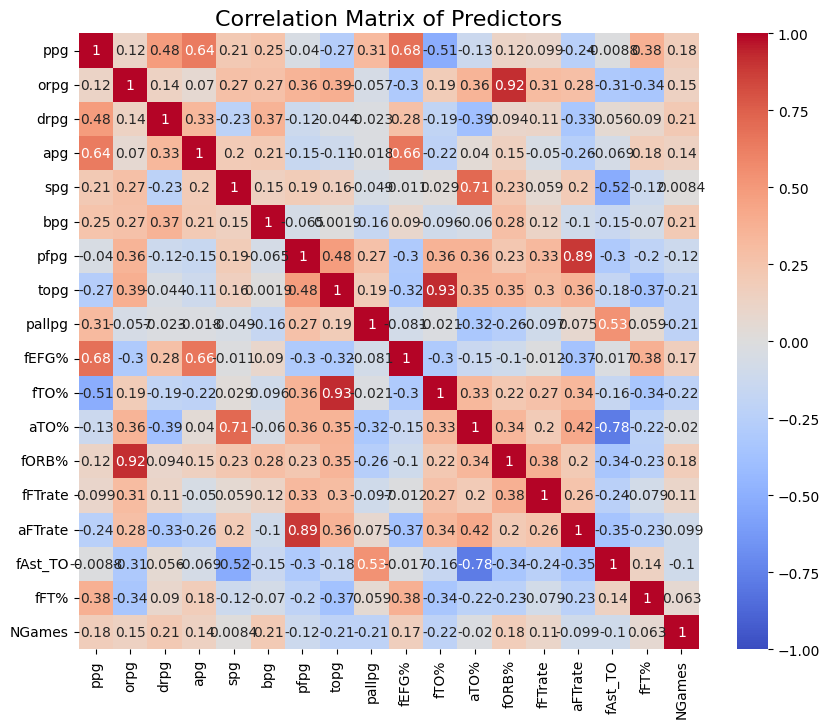

High correlations (|r| > 0.6):
ppg - apg: 0.639
ppg - fEFG%: 0.680
orpg - fORB%: 0.921
apg - fEFG%: 0.659
spg - aTO%: 0.714
pfpg - aFTrate: 0.885
topg - fTO%: 0.929
aTO% - fAst_TO: -0.776


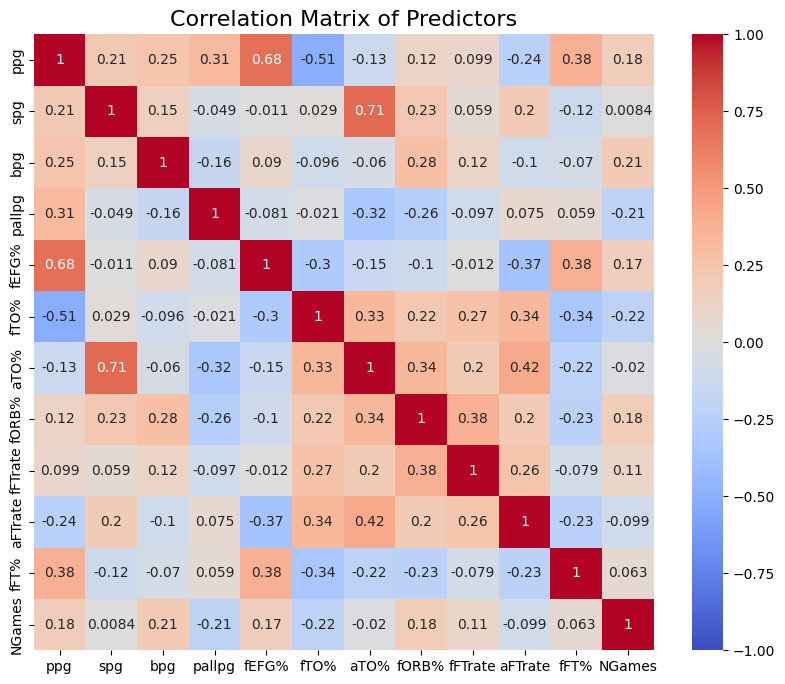

High correlations (|r| > 0.6):
ppg - fEFG%: 0.680
spg - aTO%: 0.714


In [7]:
def plot_correlation_matrix(df):
    """Plot correlation matrix for predictors."""
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Predictors', fontsize=16)
    plt.show()
    
    # Print high correlations
    print("High correlations (|r| > 0.6):")
    high_corr = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if abs(corr.iloc[i, j]) > 0.6:
                high_corr.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))
    
    for var1, var2, r in high_corr:
        print(f"{var1} - {var2}: {r:.3f}")

X_cols = ['ppg', 'orpg', 'drpg', 'apg', 'spg', 'bpg', 'pfpg', 'topg', 'pallpg', 'fEFG%',
          'fTO%', 'aTO%', 'fORB%', 'fFTrate', 'aFTrate', 'fAst_TO', 'fFT%', 'NGames']

plot_correlation_matrix(team_stats[X_cols])

# Removing columns that have high correlation with others
collinear_cols = ['orpg', 'drpg', 'apg', 'pfpg', 'topg', 'fAst_TO']
X_cols = [item for item in X_cols if item not in collinear_cols]

team_stats = team_stats[['Season', 'TeamID', 'TeamName', 'ConfAbbrev', *X_cols]]

plot_correlation_matrix(team_stats[X_cols])

In [8]:
# Number of games in each tournament a team won (including First Four)
tourney_wins = MTourney.groupby(['Season','WTeamID'])['WScore'].count().reset_index()
tourney_wins = pd.merge(t_teams, tourney_wins, 
                        left_on=['TeamID', 'Season'], right_on=['WTeamID', 'Season'], how='left')
tourney_wins = tourney_wins.fillna({'WScore': 0}).drop(columns='WTeamID')
tourney_wins = pd.merge(tourney_wins, MTeamConfs, on=['Season', 'TeamID'])
tourney_wins['FinalFour'] = np.where(tourney_wins['WScore'] >= 4, 1, 0)


In [9]:
# Average box score results for each conference-season
conf_stats = team_stats.drop(columns=['TeamName', 'TeamID'])
conf_stats = conf_stats.groupby(['Season', 'ConfAbbrev']).mean().reset_index().round(2)

conf_tourney_wins = tourney_wins.groupby(['Season', 'ConfAbbrev']).agg(
    total_wins = ('WScore', 'sum'),
    avg_wins = ('WScore', 'mean'),
    total_final_4s = ('FinalFour', 'sum'),
    total_teams = ('WScore', 'count')
).reset_index().round(2)

conf_stats = pd.merge(conf_stats, conf_tourney_wins, on=['Season', 'ConfAbbrev'])
conf_stats.sort_values('ppg', ascending=False)

def scale_stats(df):
    scaled_df = df.copy()
    
    for season in df['Season'].unique():
        season_mask = df['Season'] == season
        
        for stat in X_cols:
            szn_mean = df.loc[season_mask, stat].mean()
            szn_std = df.loc[season_mask, stat].std()
                
            scaled_df.loc[season_mask, stat] = (df.loc[season_mask, stat] - szn_mean) / szn_std
    
    return scaled_df

s_conf_stats = scale_stats(conf_stats).add_prefix('conf_')
s_team_stats = scale_stats(team_stats)
s_team_stats = pd.merge(s_team_stats,t_teams[['Season', 'TeamID', 'RSeed']], on=['Season', 'TeamID'])

In [138]:
s_all_stats = pd.merge(s_team_stats, s_conf_stats, left_on=['Season', 'ConfAbbrev'], right_on=['conf_Season', 'conf_ConfAbbrev'])
s_all_stats.drop(columns=['ConfAbbrev','conf_Season', 'conf_ConfAbbrev', 'conf_total_wins', 'conf_avg_wins', 'conf_total_final_4s', 'conf_total_teams'], inplace=True)

np.random.seed(19)

tourney_games = MTourney[['Season', 'WTeamID', 'LTeamID']]
tourney_games.columns = ['Season', 'Team0', 'Team1']
tourney_games['focus_team'] = np.random.choice([0, 1], size=len(tourney_games))
tourney_games['win'] = np.where(tourney_games['focus_team'] == 0, 1, 0)

tourney_games = tourney_games[tourney_games['Season'] >= 2003]

team1s = tourney_games[tourney_games['focus_team'] == 1]
team1s = pd.merge(team1s, s_all_stats, left_on=['Season', 'Team1'], right_on=['Season', 'TeamID'])
team1s = pd.merge(team1s, s_all_stats, left_on=['Season', 'Team0'], right_on=['Season', 'TeamID'])

team0s = tourney_games[tourney_games['focus_team'] == 0]
team0s = pd.merge(team0s, s_all_stats, left_on=['Season', 'Team0'], right_on=['Season', 'TeamID'])
team0s = pd.merge(team0s, s_all_stats, left_on=['Season', 'Team1'], right_on=['Season', 'TeamID'])

tourney_games = pd.concat([team1s,team0s])

tourney_games['SeedDiff'] = tourney_games['RSeed_x'] - tourney_games['RSeed_y']

tourney_games['Team0'] = tourney_games['TeamID_x']
tourney_games['Team1'] = tourney_games['TeamID_y']

tourney_games.drop(columns=['focus_team','TeamName_x', 'TeamName_y', 'TeamID_x', 'TeamID_y', 'RSeed_x', 'RSeed_y'], inplace=True)

tourney_games.rename(columns={'Team0': 'TeamID_x', 'Team1': 'TeamID_y'}, inplace=True)

<ipython-input-138-5437912a934e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tourney_games['focus_team'] = np.random.choice([0, 1], size=len(tourney_games))
<ipython-input-138-5437912a934e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tourney_games['win'] = np.where(tourney_games['focus_team'] == 0, 1, 0)


Optimization terminated successfully.
         Current function value: 0.539076
         Iterations 6
F1 score = 0.744
Precision = 0.726
Recall = 0.763



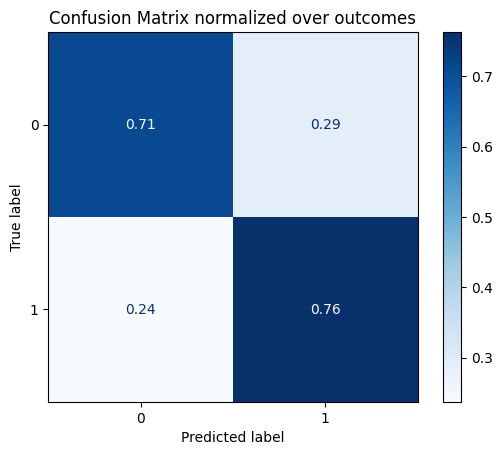

In [140]:
tourney_predictors = tourney_games.iloc[:,4:]
tourney_wins = tourney_games['win']

X = sm.add_constant(tourney_wins)

X_train, X_test, y_train, y_test = train_test_split(tourney_predictors, tourney_wins, test_size=0.2)

model = sm.Logit(y_train, X_train)

log_reg = model.fit() 

p_hat = np.array(log_reg.predict(X_test))
y_hat = p_hat > 0.5
disp = ConfusionMatrixDisplay.from_predictions(
     y_test,
     y_hat, 
     cmap=plt.cm.Blues,
     normalize='true', # Normalized over the true outcomes (rows)  
                       # Shows Type II error rates 
    )
disp.ax_.set_title('Confusion Matrix normalized over outcomes');

print('F1 score = %.3f'%f1_score(y_test, y_hat))     
print('Precision = %.3f'%precision_score(y_test, y_hat))
print('Recall = %.3f\n'%recall_score(y_test, y_hat))


In [42]:
# Run a cross-validation test for a random forest model, optimizing Brier score loss

import time

start_time = time.time()

rf = rnd_frst()

param_grid = {
    'n_estimators': [25,50,100,200],
    'max_depth': [1,2,5,10],
    'min_samples_split': [1, 2, 5],       # Minimum samples required to split a node
    'min_samples_leaf': [2, 4, 6],         # Minimum samples required at a leaf node
    
    # Feature selection parameters
    'max_features': ['auto', 'sqrt', None],  # Number of features to consider for best split

    'criterion': ['gini', 'entropy']      # Function to measure quality of split (for classifier)
}

brier_scorer = make_scorer(brier_score_loss, needs_proba=True, greater_is_better=False)

# Perform grid search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring=brier_scorer, n_jobs=-1)
grid_search.fit(tourney_predictors, tourney_wins)

print("Best parameters:", grid_search.best_params_)
print("Best Brier Score:", grid_search.best_score_)

print("Time:", time.time() - start_time)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1440 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1440 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 100}
Best Brier Score: -0.19526864084989687
Time: 547.6896188259125


In [83]:
# Testing whether performance changes by season
seasons = tourney_games['Season'].unique()
results = []

#best_model = grid_search.best_estimator_

for test_season in seasons:
    # Split data
    train_data = tourney_games[tourney_games['Season'] != test_season]
    test_data = tourney_games[tourney_games['Season'] == test_season]
    
    # Separate features and target
    X_train = train_data.drop(['win', 'Season', 'Team0', 'Team1'], axis=1)
    y_train = train_data['win']
    X_test = test_data.drop(['win', 'Season', 'Team0', 'Team1'], axis=1)
    y_test = test_data['win']

    y_pred_proba = calibrated_model.predict_proba(X_test)[:, 1]
    
    # Calculate Brier score
    brier = brier_score_loss(y_test, y_pred_proba)
    
    # Store results
    results.append({
        'season': test_season,
        'brier_score': brier,
        'num_samples': len(test_data)
    })

test = pd.DataFrame(results)

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2021 2022 2023 2024]
[2003 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2021 2022 2023 2024]
[2003 2004 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2021 2022 2023 2024]
[2003 2004 2005 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2021 2022 2023 2024]
[2003 2004 2005 2006 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2021 2022 2023 2024]
[2003 2004 2005 2006 2007 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2021 2022 2023 2024]
[2003 2004 2005 2006 2007 2008 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2021 2022 2023 2024]
[2003 2004 2005 2006 2007 2008 2009 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2021 2022 2023 2024]
[2003 2004 2005 2006 2007 2008 2009 2010 2012 2013 2014 2015 2016 2017
 2018 2019 2021 2022 2023 2024]
[2003 2004 2005 2006 2007 2008 2009 2010 2011 2013 2014 2015 2016 2017
 2

,season,brier_score,num_samples
0,2003,0.143728,64
1,2004,0.110942,64
2,2005,0.139124,64
3,2006,0.148192,64
4,2007,0.095987,64
5,2008,0.113021,64
6,2009,0.117969,64
7,2010,0.169713,64
8,2011,0.161442,67
9,2012,0.137987,67


F1 score = 0.780
Precision = 0.767
Recall = 0.794



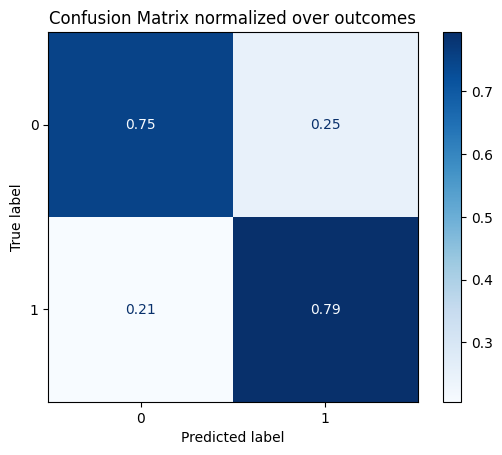

In [86]:
X_train, X_test, y_train, y_test = train_test_split(tourney_predictors, tourney_wins, test_size=0.2)


model = rnd_frst(criterion='entropy', max_depth=5, max_features=None,
                                   min_samples_leaf=4, min_samples_split=2, n_estimators=50,
                                   random_state=42)
model.fit(X_train, y_train)
p_hat = calibrated_model.predict_proba(X_test)[:,1]
y_hat = p_hat > 0.5
disp = ConfusionMatrixDisplay.from_predictions(
     y_test,
     y_hat, 
     cmap=plt.cm.Blues,
     normalize='true', # Normalized over the true outcomes (rows)  
                       # Shows Type II error rates 
    )
disp.ax_.set_title('Confusion Matrix normalized over outcomes');

print('F1 score = %.3f'%f1_score(y_test, y_hat))     
print('Precision = %.3f'%precision_score(y_test, y_hat))
print('Recall = %.3f\n'%recall_score(y_test, y_hat))


In [99]:
tourney_games_small = tourney_games[tourney_games['Season'] != 2024]

tourney_predictors = tourney_games_small.iloc[:,4:]
tourney_wins = tourney_games_small['win']

X_train, X_test, y_train, y_test = train_test_split(tourney_predictors, tourney_wins, test_size=0.2)

best_model = grid_search.best_estimator_

X_last_szn = tourney_games[tourney_games['Season'] == 2024].iloc[:,4:]
y_last_szn = tourney_games[tourney_games['Season'] == 2024]['win']

p_hat = best_model.predict_proba(X_last_szn)[:,1]


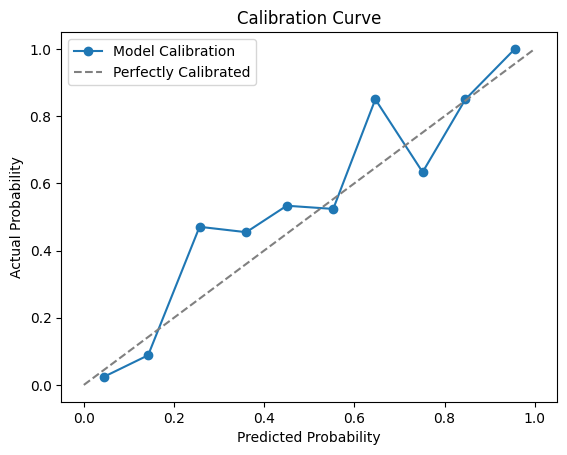

In [96]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, p_hat, n_bins=10)

plt.plot(prob_pred, prob_true, marker="o", label="Model Calibration")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly Calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Probability")
plt.legend()
plt.title("Calibration Curve")
plt.show()

In [100]:
# Incorporating Platt scaling for accuracy at edges

from sklearn.calibration import CalibratedClassifierCV

X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2)

calibrated_model = CalibratedClassifierCV(best_model, method="sigmoid", cv="prefit")
calibrated_model.fit(X_val, y_val)

p_hat = calibrated_model.predict_proba(X_last_szn)[:, 1]

In [101]:
brier = brier_score_loss(y_last_szn, p_hat)
logloss = log_loss(y_last_szn, p_hat)

print(f"Brier Score: {brier:.4f}")
print(f"Log Loss: {logloss:.4f}")

Brier Score: 0.1471
Log Loss: 0.4501
